# VEEGAN 

The coding style of this notebook is inspired by some of Ben Poole's work. Especially the use of `graph_replace` method. 

## Imports

In [1]:
%pylab inline
import tensorflow as tf
import itertools
import seaborn as sns
slim = tf.contrib.slim
ds = tf.contrib.distributions
st = tf.contrib.bayesflow.stochastic_tensor
graph_replace = tf.contrib.graph_editor.graph_replace

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
params = {
    'batch_size': 500,
    'latent_dim': 2, 
    'eps_dim': 1, 
    'input_dim': 254, 
    'n_layer_disc': 2,
    'n_hidden_disc': 128,
    'n_layer_gen': 2,
    'n_hidden_gen': 128,
    'n_layer_inf': 2,
    'n_hidden_inf': 128,
}


## Generate 2D Grid

In [3]:
def create_distribution(batch_size, num_components=25, num_features=2,**kwargs):
    cat = ds.Categorical(tf.zeros(num_components, dtype=float32))
    mus = np.array([np.array([i, j]) for i, j in itertools.product(range(-4, 5, 2),
                                                           range(-4, 5, 2))],dtype=float32)

    s = 0.05
    sigmas = [np.array([s,s]).astype(float32) for i in range(num_components)]
    components = list((ds.MultivariateNormalDiag(mu, sigma) 
                       for (mu, sigma) in zip(mus, sigmas)))
    data = ds.Mixture(cat, components)
    return data.sample(batch_size)



## Network definitions

In [4]:
def standard_normal(shape, **kwargs):
    """Create a standard Normal StochasticTensor."""
    return st.StochasticTensor(
        ds.MultivariateNormalDiag(mu=tf.zeros(shape), diag_stdev=tf.ones(shape), **kwargs))

def normal_mixture(shape, **kwargs):
    return create_distribution(shape[0],25,shape[1],**kwargs)



def generative_network(batch_size, latent_dim, input_dim, n_layer, n_hidden, eps=1e-6,X=None):
    with tf.variable_scope("generative"):
        
        z = normal_mixture([batch_size, latent_dim], name="p_z")
        h = slim.fully_connected(z, n_hidden, activation_fn=tf.nn.relu)
        h = slim.fully_connected(h, n_hidden, activation_fn=tf.nn.relu)
        p = slim.fully_connected(h, input_dim, activation_fn=None)
        x = st.StochasticTensor(ds.Normal(p*tf.ones(input_dim), 1*tf.ones(input_dim), name="p_x"))
    return [x, z]


def inference_network(x, latent_dim, n_layer, n_hidden, eps_dim):
    eps = standard_normal([x.get_shape().as_list()[0], eps_dim], name="eps").value()
    h = tf.concat([x, eps], 1)
    with tf.variable_scope("inference"):
        h = slim.fully_connected(h, n_hidden, activation_fn=tf.nn.relu)
        h = slim.fully_connected(h, n_hidden, activation_fn=tf.nn.relu)
        z = slim.fully_connected(h, latent_dim, activation_fn=None, scope="q_z")
    return z

def data_network(x, z, n_layers=2, n_hidden=128, activation_fn=None):
    h = tf.concat([x, z], 1)
    with tf.variable_scope('discriminator'):
        h = slim.fully_connected(h, n_hidden, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=activation_fn)
    return tf.squeeze(log_d, squeeze_dims=[1])

## Construct model and training ops

In [5]:
tf.reset_default_graph()

x = tf.random_normal([params['batch_size'], params['input_dim']])

p_x, p_z = generative_network(params['batch_size'], params['latent_dim'], params['input_dim'],
                              params['n_layer_gen'], params['n_hidden_gen'])

q_z = inference_network(x, params['latent_dim'], params['n_layer_inf'], params['n_hidden_inf'],
                       params['eps_dim'])



log_d_prior = data_network(p_x, p_z, n_layers=params['n_layer_disc'],
                           n_hidden=params['n_hidden_disc'])
log_d_posterior = data_network(x, q_z, n_layers=params['n_layer_disc'],
                           n_hidden=params['n_hidden_disc'])


disc_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=log_d_posterior, labels=tf.ones_like(log_d_posterior)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=log_d_prior, labels=tf.zeros_like(log_d_prior)))


recon_likelihood_prior =p_x.distribution.log_prob(x)
recon_likelihood = tf.reduce_sum(graph_replace(recon_likelihood_prior, {p_z: q_z}), [1])


gen_loss = tf.reduce_mean(log_d_posterior) - tf.reduce_mean(recon_likelihood)

qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
opt = tf.train.AdamOptimizer(1e-3, beta1=.5)

train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars)

INFO:tensorflow:Copying op: generative/fully_connected/MatMul
INFO:tensorflow:Copying op: generative/fully_connected/BiasAdd
INFO:tensorflow:Copying op: generative/fully_connected/Relu
INFO:tensorflow:Copying op: generative/fully_connected_1/MatMul
INFO:tensorflow:Copying op: generative/fully_connected_1/BiasAdd
INFO:tensorflow:Copying op: generative/fully_connected_1/Relu
INFO:tensorflow:Copying op: generative/fully_connected_2/MatMul
INFO:tensorflow:Copying op: generative/fully_connected_2/BiasAdd
INFO:tensorflow:Copying op: generative/mul
INFO:tensorflow:Copying op: generative/p_x/mu
INFO:tensorflow:Copying op: generative/p_x/log_prob/standardize/sub
INFO:tensorflow:Copying op: generative/p_x/log_prob/standardize/truediv
INFO:tensorflow:Copying op: generative/p_x/log_prob/Square
INFO:tensorflow:Copying op: generative/p_x/log_prob/mul
INFO:tensorflow:Copying op: generative/p_x/log_prob/sub_1
INFO:tensorflow:Finalizing op: generative/fully_connected/MatMul
INFO:tensorflow:Finalizing o

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## Train model

  0%|          | 0/100 [00:00<?, ?it/s]

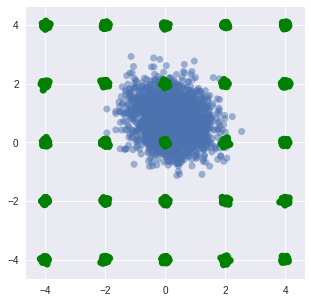

  1%|          | 1/100 [00:10<17:33, 10.64s/it]

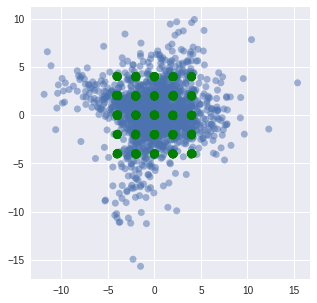

  2%|▏         | 2/100 [00:20<16:51, 10.32s/it]

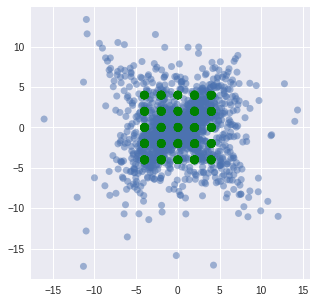

  3%|▎         | 3/100 [00:29<16:19, 10.10s/it]

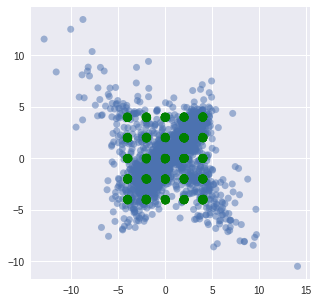

  4%|▍         | 4/100 [00:39<15:54,  9.94s/it]

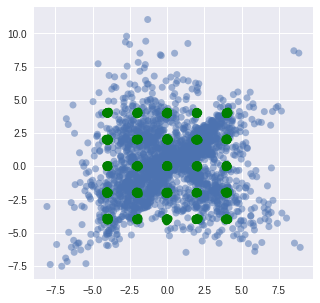

  5%|▌         | 5/100 [00:48<15:33,  9.83s/it]

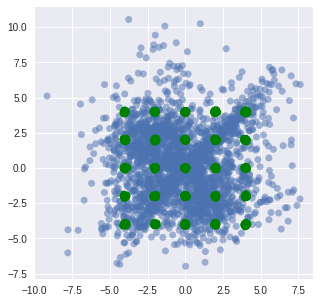

  6%|▌         | 6/100 [00:58<15:17,  9.76s/it]

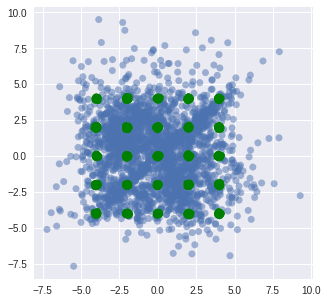

  7%|▋         | 7/100 [01:08<15:03,  9.71s/it]

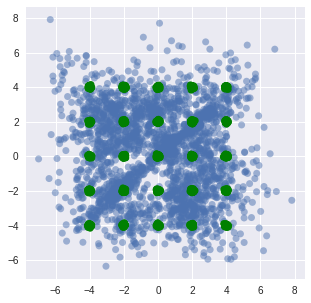

  8%|▊         | 8/100 [01:17<14:50,  9.68s/it]

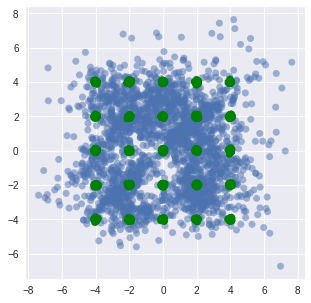

  9%|▉         | 9/100 [01:27<14:38,  9.66s/it]

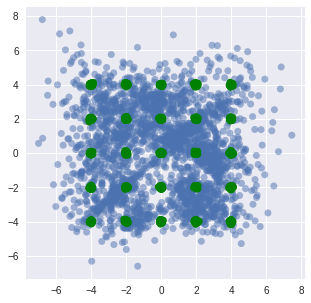

 10%|█         | 10/100 [01:36<14:26,  9.62s/it]

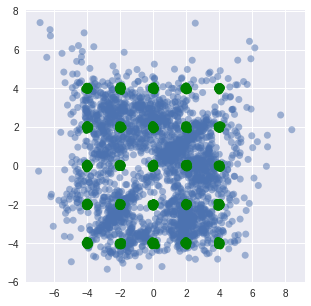

 11%|█         | 11/100 [01:46<14:16,  9.63s/it]

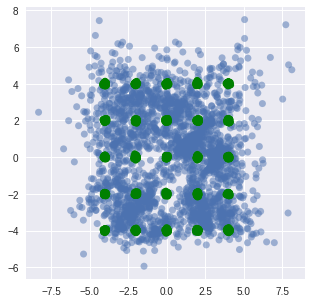

 12%|█▏        | 12/100 [01:56<14:11,  9.67s/it]

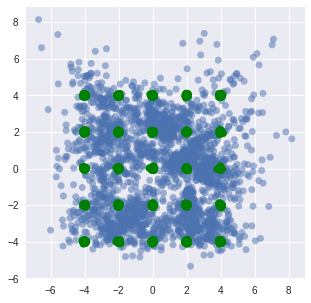

 13%|█▎        | 13/100 [02:05<14:00,  9.66s/it]

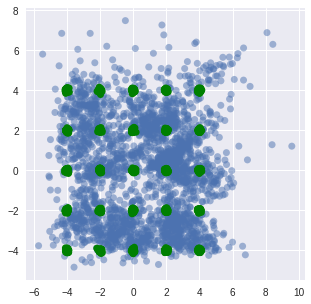

 14%|█▍        | 14/100 [02:15<13:49,  9.65s/it]

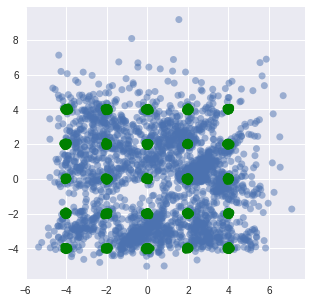

 15%|█▌        | 15/100 [02:25<13:39,  9.64s/it]

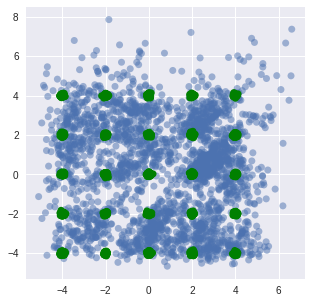

 16%|█▌        | 16/100 [02:34<13:30,  9.64s/it]

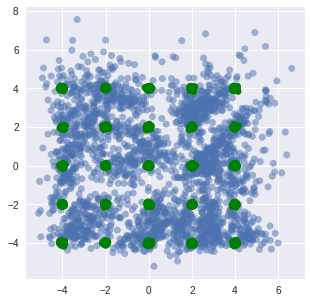

 17%|█▋        | 17/100 [02:44<13:19,  9.63s/it]

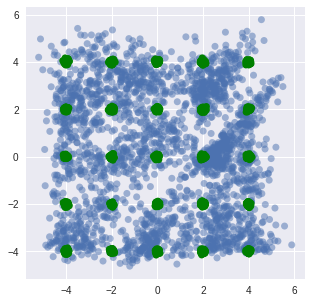

 18%|█▊        | 18/100 [02:54<13:15,  9.70s/it]

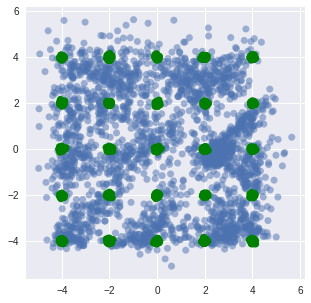

 19%|█▉        | 19/100 [03:03<13:04,  9.68s/it]

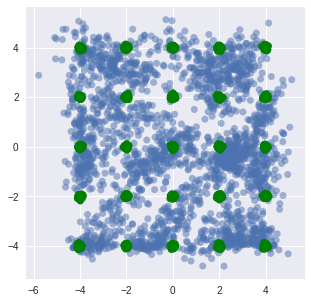

 20%|██        | 20/100 [03:13<12:52,  9.66s/it]

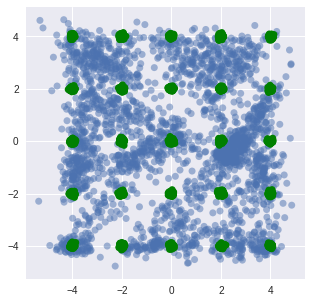

 21%|██        | 21/100 [03:23<12:42,  9.65s/it]

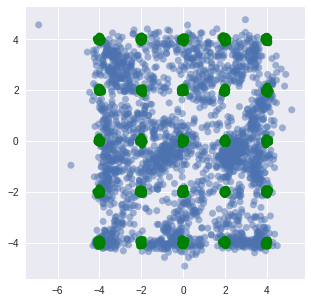

 22%|██▏       | 22/100 [03:32<12:30,  9.62s/it]

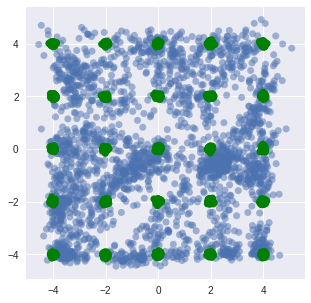

 23%|██▎       | 23/100 [03:42<12:20,  9.62s/it]

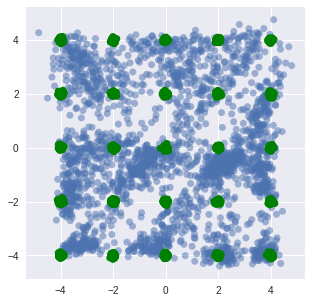

 24%|██▍       | 24/100 [03:51<12:10,  9.61s/it]

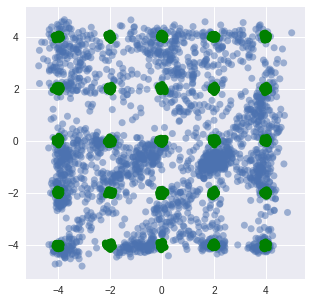

 25%|██▌       | 25/100 [04:01<12:00,  9.60s/it]

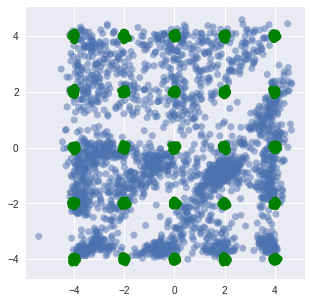

 26%|██▌       | 26/100 [04:11<11:49,  9.59s/it]

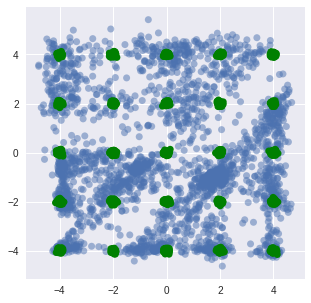

 27%|██▋       | 27/100 [04:20<11:39,  9.58s/it]

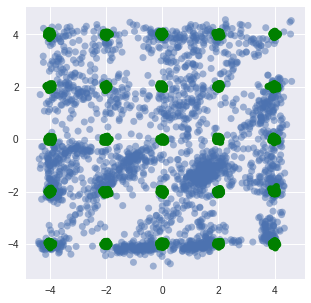

 28%|██▊       | 28/100 [04:30<11:29,  9.58s/it]

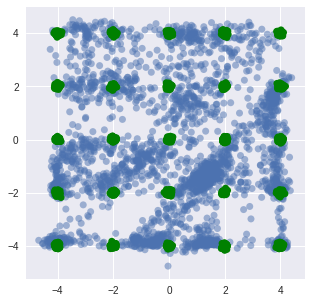

 29%|██▉       | 29/100 [04:39<11:19,  9.57s/it]

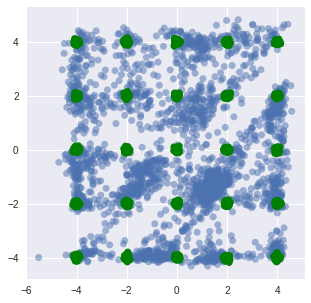

 30%|███       | 30/100 [04:49<11:13,  9.62s/it]

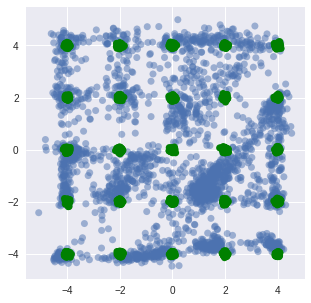

 31%|███       | 31/100 [04:59<11:02,  9.60s/it]

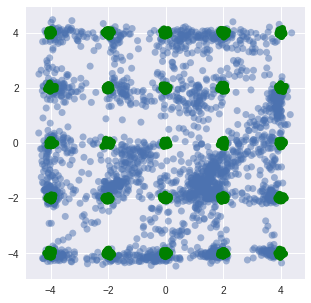

 32%|███▏      | 32/100 [05:08<10:51,  9.58s/it]

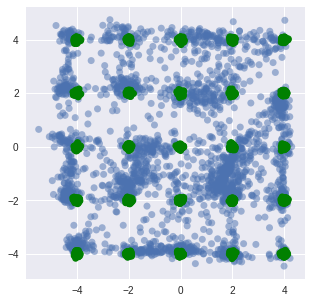

 33%|███▎      | 33/100 [05:18<10:42,  9.59s/it]

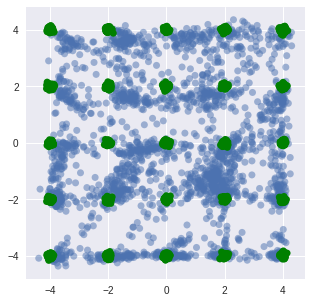

 34%|███▍      | 34/100 [05:27<10:33,  9.59s/it]

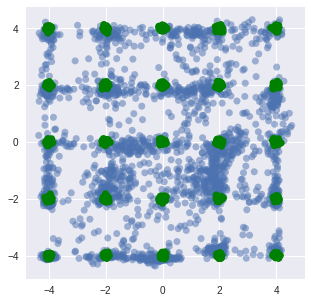

 35%|███▌      | 35/100 [05:37<10:22,  9.58s/it]

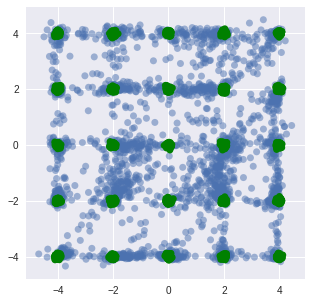

 36%|███▌      | 36/100 [05:46<10:13,  9.58s/it]

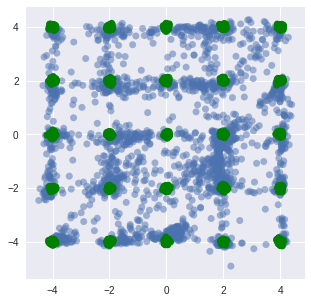

 37%|███▋      | 37/100 [05:56<10:02,  9.57s/it]

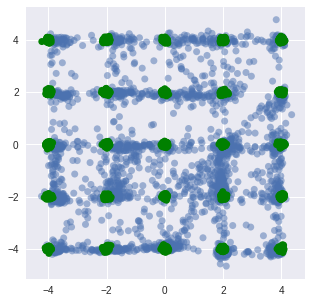

 38%|███▊      | 38/100 [06:06<09:54,  9.59s/it]

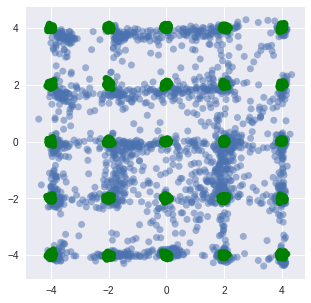

 39%|███▉      | 39/100 [06:15<09:45,  9.60s/it]

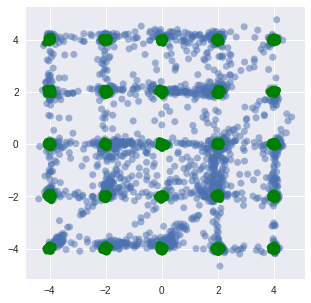

 40%|████      | 40/100 [06:25<09:35,  9.59s/it]

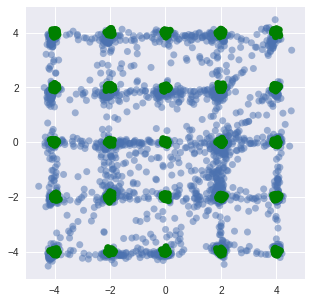

 41%|████      | 41/100 [06:34<09:25,  9.58s/it]

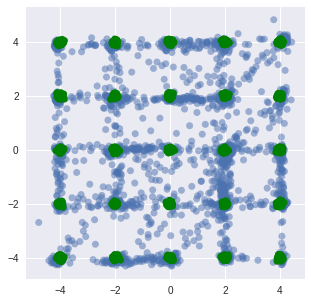

 42%|████▏     | 42/100 [06:44<09:14,  9.57s/it]

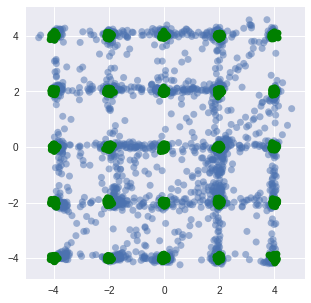

 43%|████▎     | 43/100 [06:53<09:05,  9.56s/it]

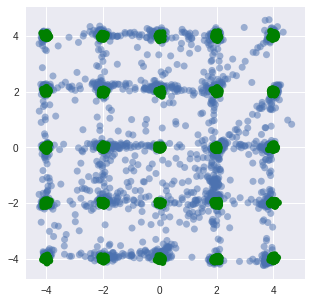

 44%|████▍     | 44/100 [07:03<08:55,  9.57s/it]

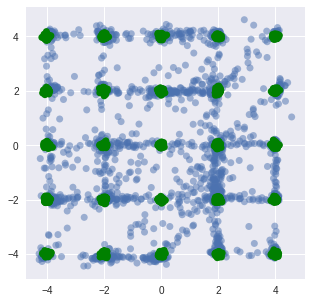

 45%|████▌     | 45/100 [07:13<08:46,  9.57s/it]

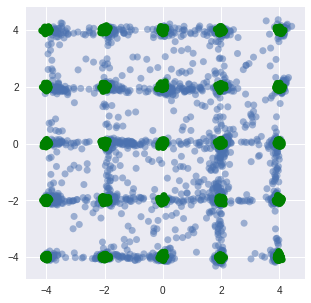

 46%|████▌     | 46/100 [07:22<08:36,  9.57s/it]

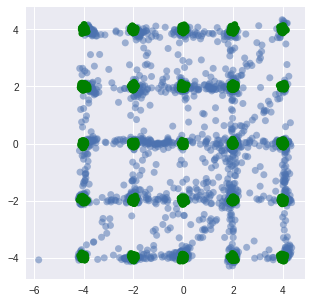

 47%|████▋     | 47/100 [07:32<08:27,  9.57s/it]

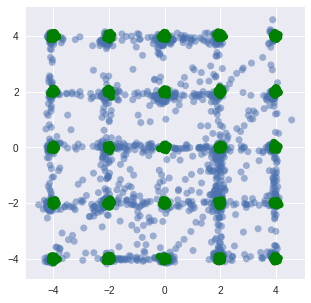

 48%|████▊     | 48/100 [07:41<08:17,  9.57s/it]

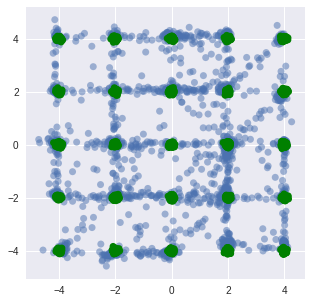

 49%|████▉     | 49/100 [07:51<08:11,  9.63s/it]

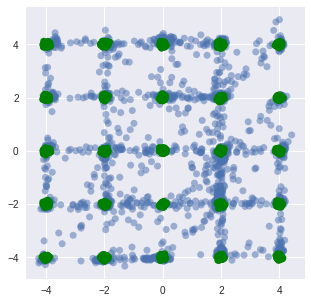

 50%|█████     | 50/100 [08:01<07:59,  9.60s/it]

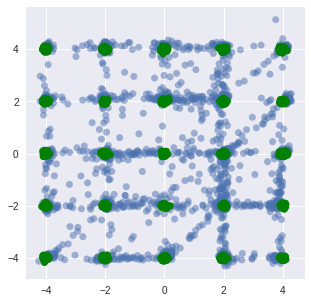

 51%|█████     | 51/100 [08:10<07:50,  9.60s/it]

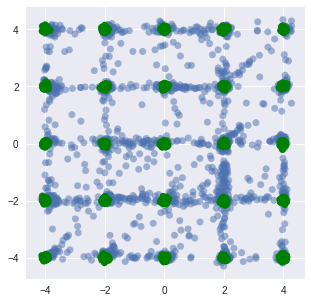

 52%|█████▏    | 52/100 [08:20<07:40,  9.59s/it]

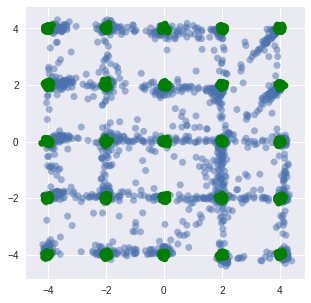

 53%|█████▎    | 53/100 [08:29<07:30,  9.59s/it]

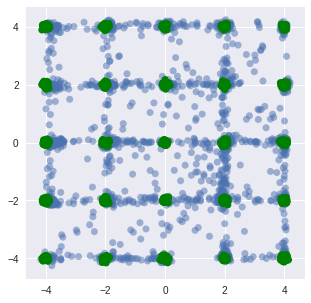

 54%|█████▍    | 54/100 [08:39<07:20,  9.58s/it]

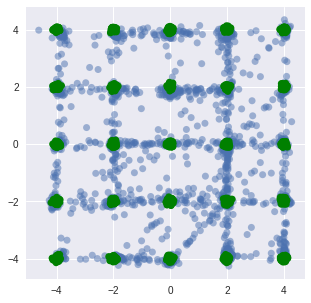

 55%|█████▌    | 55/100 [08:48<07:10,  9.56s/it]

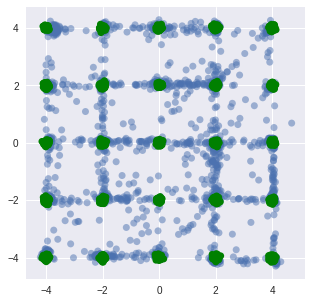

 56%|█████▌    | 56/100 [08:58<07:00,  9.57s/it]

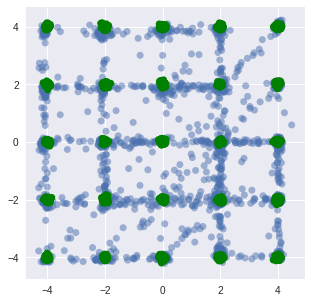

 57%|█████▋    | 57/100 [09:08<06:51,  9.56s/it]

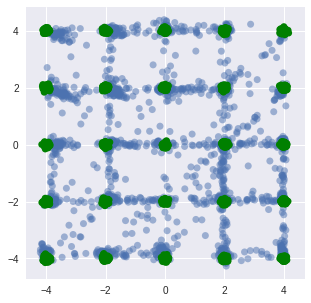

 58%|█████▊    | 58/100 [09:17<06:41,  9.56s/it]

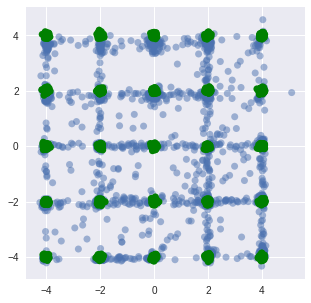

 59%|█████▉    | 59/100 [09:27<06:31,  9.55s/it]

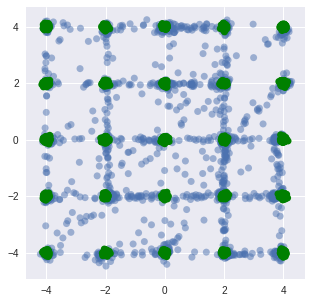

 60%|██████    | 60/100 [09:36<06:21,  9.55s/it]

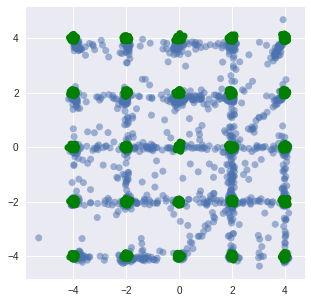

 61%|██████    | 61/100 [09:46<06:12,  9.56s/it]

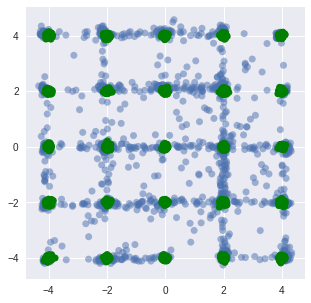

 62%|██████▏   | 62/100 [09:55<06:03,  9.56s/it]

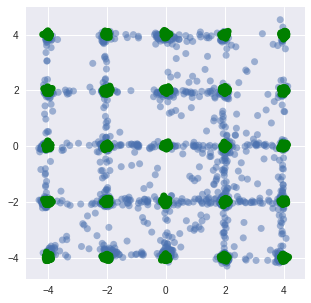

 63%|██████▎   | 63/100 [10:05<05:53,  9.54s/it]

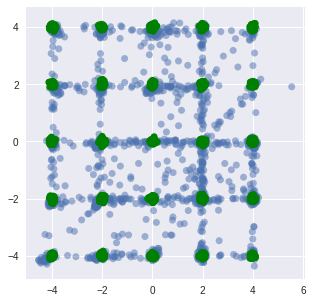

 64%|██████▍   | 64/100 [10:14<05:43,  9.54s/it]

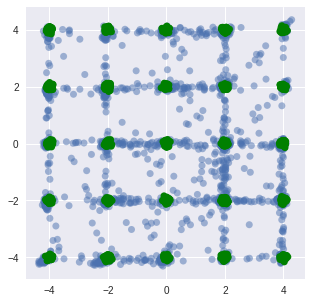

 65%|██████▌   | 65/100 [10:24<05:33,  9.54s/it]

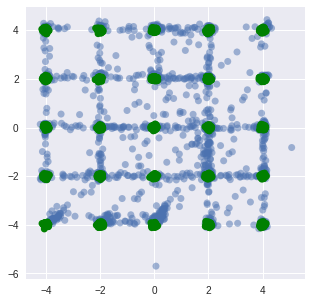

 66%|██████▌   | 66/100 [10:33<05:24,  9.55s/it]

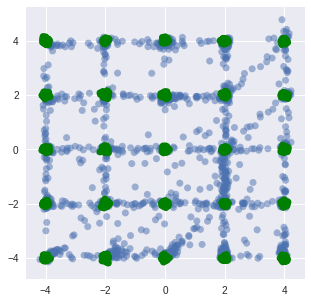

 67%|██████▋   | 67/100 [10:43<05:14,  9.54s/it]

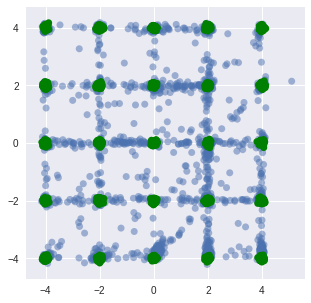

 68%|██████▊   | 68/100 [10:53<05:06,  9.59s/it]

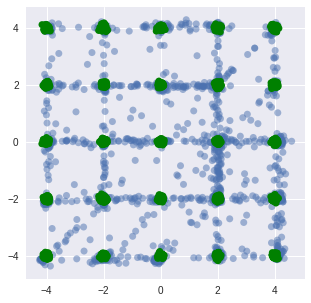

 69%|██████▉   | 69/100 [11:02<04:57,  9.59s/it]

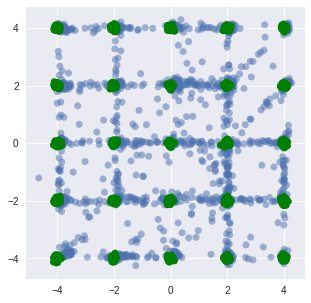

 70%|███████   | 70/100 [11:12<04:47,  9.57s/it]

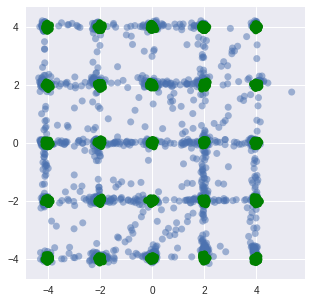

 71%|███████   | 71/100 [11:21<04:37,  9.57s/it]

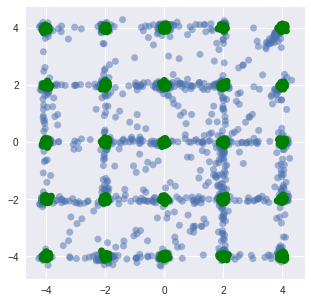

 72%|███████▏  | 72/100 [11:31<04:28,  9.57s/it]

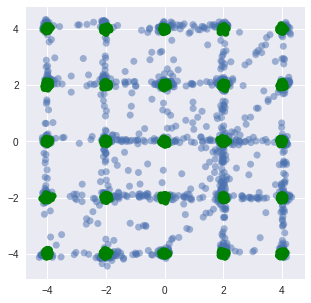

 73%|███████▎  | 73/100 [11:40<04:18,  9.56s/it]

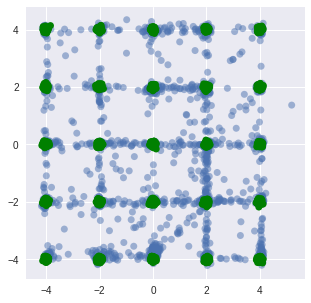

 74%|███████▍  | 74/100 [11:50<04:08,  9.56s/it]

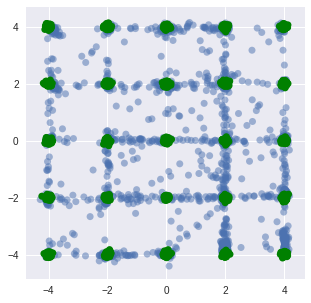

 75%|███████▌  | 75/100 [12:00<03:59,  9.57s/it]

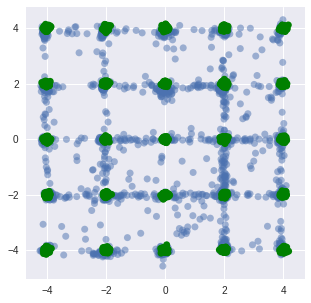

 76%|███████▌  | 76/100 [12:09<03:49,  9.56s/it]

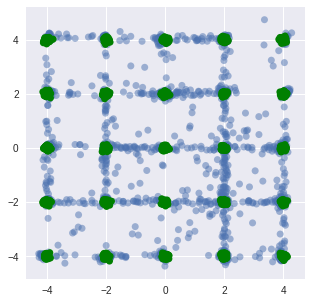

 77%|███████▋  | 77/100 [12:19<03:39,  9.55s/it]

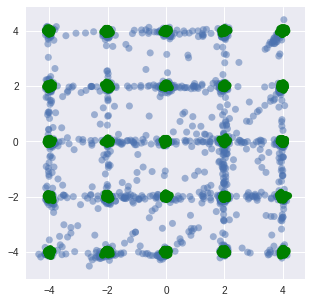

 78%|███████▊  | 78/100 [12:28<03:29,  9.54s/it]

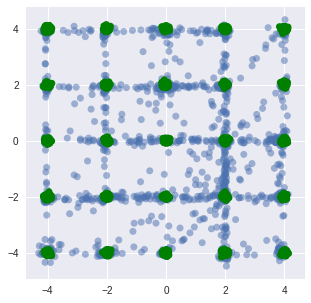

 79%|███████▉  | 79/100 [12:38<03:20,  9.55s/it]

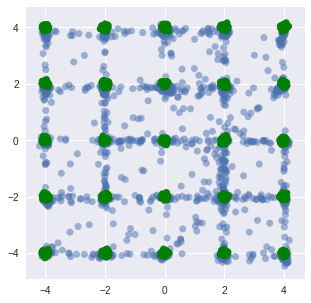

 80%|████████  | 80/100 [12:47<03:10,  9.54s/it]

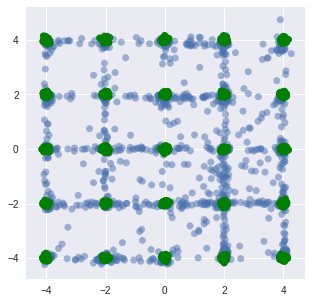

 81%|████████  | 81/100 [12:57<03:02,  9.61s/it]

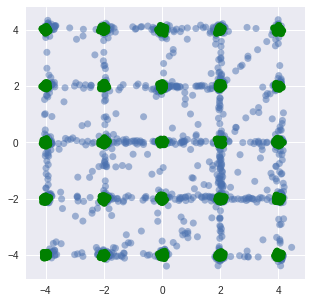

 82%|████████▏ | 82/100 [13:07<02:52,  9.60s/it]

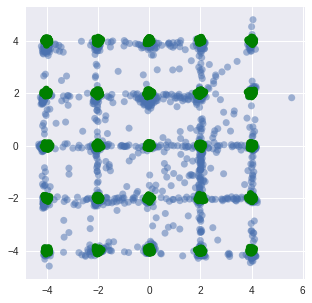

 83%|████████▎ | 83/100 [13:16<02:42,  9.58s/it]

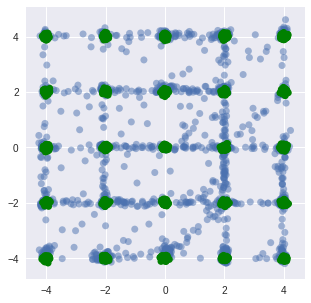

 84%|████████▍ | 84/100 [13:26<02:33,  9.58s/it]

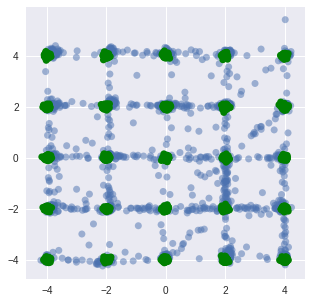

 85%|████████▌ | 85/100 [13:35<02:23,  9.57s/it]

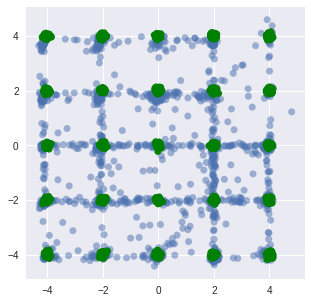

 86%|████████▌ | 86/100 [13:45<02:14,  9.57s/it]

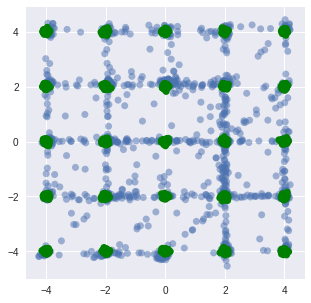

 87%|████████▋ | 87/100 [13:55<02:05,  9.63s/it]

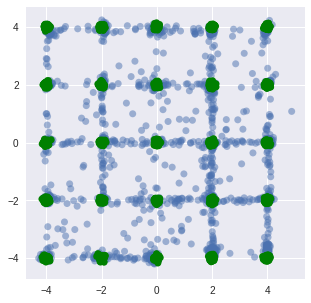

 88%|████████▊ | 88/100 [14:04<01:55,  9.61s/it]

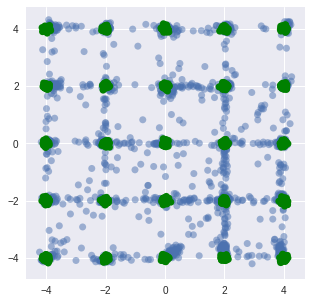

 89%|████████▉ | 89/100 [14:14<01:45,  9.59s/it]

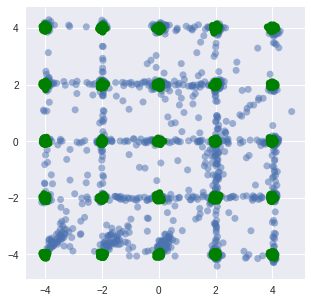

 90%|█████████ | 90/100 [14:23<01:35,  9.58s/it]

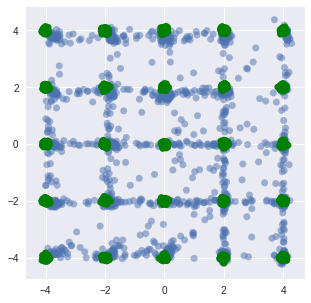

 91%|█████████ | 91/100 [14:33<01:26,  9.56s/it]

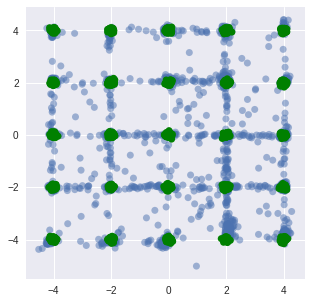

 92%|█████████▏| 92/100 [14:42<01:16,  9.56s/it]

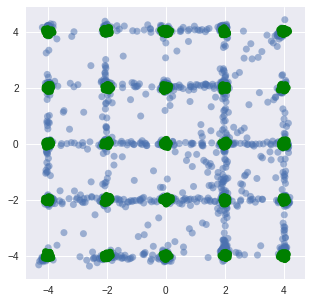

 93%|█████████▎| 93/100 [14:52<01:06,  9.56s/it]

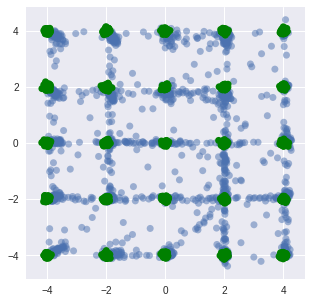

 94%|█████████▍| 94/100 [15:01<00:57,  9.56s/it]

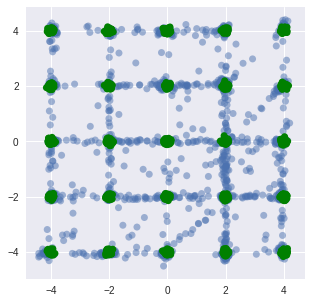

 95%|█████████▌| 95/100 [15:11<00:47,  9.55s/it]

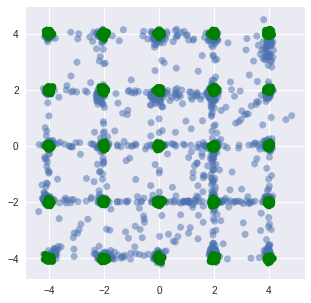

 96%|█████████▌| 96/100 [15:21<00:38,  9.55s/it]

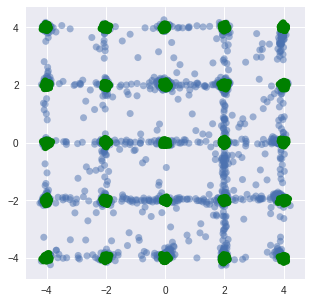

 97%|█████████▋| 97/100 [15:30<00:28,  9.55s/it]

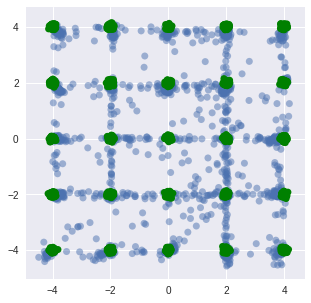

 98%|█████████▊| 98/100 [15:40<00:19,  9.57s/it]

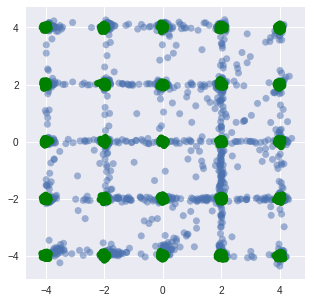

 99%|█████████▉| 99/100 [15:49<00:09,  9.57s/it]

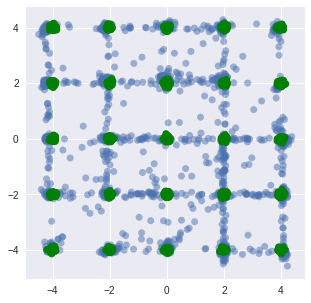

100%|██████████| 100/100 [15:59<00:00,  9.56s/it]


In [7]:
from tqdm import tqdm
import collections
fs = []

total_batch = 1000

#  Training cycle
for epoch in tqdm(xrange(100)):
    xx = np.vstack([sess.run(q_z) for _ in range(5)])
    yy= np.vstack([sess.run(p_z) for _ in range(5)])
    fig_= figure(figsize=(5,5), facecolor='w')

    scatter(xx[:, 0], xx[:, 1],
            edgecolor='none', alpha=0.5)
    scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none')
    show()
    
    
#     Loop over all batches
    for i in range(total_batch):
        _ = sess.run([[gen_loss, disc_loss], train_gen_op,train_disc_op])



    

Number of Modes Captured:  25
Number of Points Falling Within 3 std. of the Nearest Mode  1360


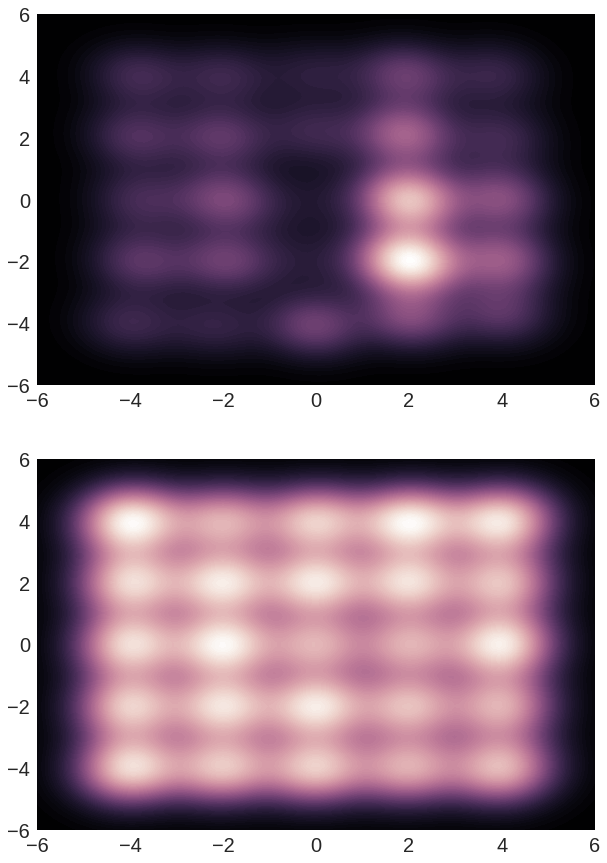

In [8]:
'''Sample 2500 points'''
xx = np.vstack([sess.run(q_z) for _ in range(5)])
yy= np.vstack([sess.run(p_z) for _ in range(5)])


'''KDE Plots'''
sns.set(font_scale=2)
f, (ax1,ax2) = plt.subplots(2,figsize=(10, 15))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(xx[:, 0], xx[:,1], cmap=cmap, ax=ax1, n_levels=100, shade=True, clip=[[-6, 6]]*2)
sns.kdeplot(yy[:, 0], yy[:,1], cmap=cmap,ax=ax2, n_levels=100, shade=True, clip=[[-6, 6]]*2)


'''Evaluation'''
MEANS = np.array([np.array([i, j]) for i, j in itertools.product(range(-4, 5, 2),
                                                           range(-4, 5, 2))],dtype=float32)
l2_store=[]
for x_ in xx:
    l2_store.append([np.sum((x_-i)**2)  for i in MEANS])
    
mode=numpy.argmin(l2_store,1).flatten().tolist()
dis_ = [l2_store[j][i] for j,i in enumerate(mode)]
mode_counter = [mode[i] for i in range(len(mode)) if numpy.sqrt(dis_[i])<=0.15]

print 'Number of Modes Captured: ',len(collections.Counter(mode_counter))
print 'Number of Points Falling Within 3 std. of the Nearest Mode ',numpy.sum(collections.Counter(mode_counter).values())